In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from scipy import interpolate

In [3]:
m = 4

eps = 1
omega = 1
T = 1e9

buk_vis = 6.0*10**(-59) * eps**2 * omega**(-2) * T**6
shear_vis = 347 * eps**(9/4) * T**(-2)

In [4]:
def freq_omega(Omega): # eigen frequency
    
    return 1

def alpha_m(m,M,R,period=0): # period is in unit second
    if period == 0:
        return 1
    else:
        # (piGrho) 3/4* gravitational constant in solar mass^-1*km^3*sec^-2 = 9.95e10
        unit = (9.95e10*(M/R**3))**(-0.5) # in solar mass and km
        template = np.genfromtxt("./Constant/alpha%s.txt"%m,names=('x,y'))
        f = interpolate.interp1d(template['x'], template['y'])

        freq = (2*np.pi/period)*(unit)
        if freq > 0.65:
            freq = 0.65

        am = f(freq)
        return round(np.float(am),5)
#         return 1

def gamma_m(m,M,R,period=0): # period is in unit second
    if period == 0:
        return 1
    else:
        unit = (9.95e10*(M/R**3))**(-0.5) # in solar mass and km
        template = np.genfromtxt("./Constant/gamma%s.txt"%m,names=('x,y'))
        f = interpolate.interp1d(template['x'], template['y'])

        freq = (2*np.pi/period)*(unit)
        if freq > 0.65:
            freq = 0.65

        gm = f(freq)

        return round(np.float(gm),5)
    
def epslion_m(m):
    return 1


def omega_m(m,M,R): # mass and radius (equation 16.70)
    col1 = 2*m*(m - 1)/(2*m + 1)
    col2 = 6.67e-20*M*2e30/R**3
    om = np.sqrt(col1 * col2)
    return om

In [21]:
def doublefactorial(n): 
    if (n == 0 or n == 1): 
        return 1; 
    return n * doublefactorial(n - 2);


def tau_GR_m(m,M,R): # m >= 0, mass, radius
    col1 = ( (m-1) * (doublefactorial(2*m+1))**2 ) / ( (m+1) * (m+2) )
    col2 = ( (2*m + 1) / (2*m*(m-1)) )**m
    col3 = 2/3 * (R/(M*1.48))**(m+1) * R/3e5
    tGRm = col1 * col2 * col3
    return tGRm

def tau_nu_m(m,M,R,nu=0,T=1e9): # radius (km), M (solar mass), T(K)
    rho = 3*M*1.98843e33/(4*np.pi*(R*1e5)**3) # gram cm^-3
    if nu == 0:
        nu = 347*rho**(5/4)*T**(-2)
    tnum = (R*1e5)**2 / ((2*m+1)*(m-1)) / nu
    return tnum

def tau_zeta_m(m,M,R,zeta=0,T=1e9,w4=1): # mass(sun mass) radius (km)
    M = M*1.98843e33 # gram 
    R = R*1e5 # cm
    rho = 3*M/(4*np.pi*R**3) 
    T9=T/1e9
    zetaM = 5e18*T9**6/w4**2
    zetaD = 5e24*T9**4/w4**2
    zetaE = 1e30*T9**2/w4**2
    if zeta == 0:
        zeta = zetaM
    tzetam = (0.5*(3/5)**4 * (m**3/(2*m+3)) * zeta/(rho*R**2))**(-1)
    return tzetam

tau_GR_m(2,1.4,13),tau_nu_m(2,1.4,13),tau_zeta_m(2,1.4,13)

(0.20903207914839314, 772125028.0432831, 1380604942.229225)

In [22]:
def Omega_GRR(m,M,R,nu=0,zeta=0,O=0,T=1e9): # mass, radius, shear viscosity, bulk viscosity, initial frequency
    col1 = omega_m(m,M,R)/m
    col2 = alpha_m(m,M,R,O) 
    col_25 = tau_GR_m(m,M,R)/tau_nu_m(m,M,R,nu,T) + tau_GR_m(m,M,R)/tau_zeta_m(m,M,R,zeta,T)*epslion_m(m)
    col3 = gamma_m(m,M,R,O) * (col_25)**(1/(2*m+1))
    GRR = col1 * (col2 + col3)
    return 2*np.pi/GRR #unit in second

def self_con_Omega_GRR(m,M,R,nu=0,zeta=0,O=0,T=1e9):
    period = []
    for i in range(30):
        O = 2*np.pi/Omega_GRR(m,M,R,nu,zeta,O,T)
        period.append(2*np.pi/O)
#     plt.figure(figsize=(10,5))
#     plt.plot(period)
#     plt.show()
    final_p = 0.5*(period[-1]+period[-2])
    return np.round(final_p,7) # in unit second

self_con_Omega_GRR(5,1.4,13)

0.0011905

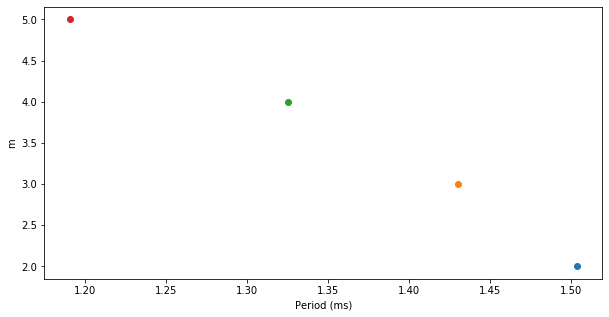

In [23]:
mass = 1.4
radius = 13
plt.figure(figsize=(10,5))
for m in range(2,6):
    y = Omega_GRR(m,mass,radius)*1000
    plt.plot(y,m,'o-')
plt.xlabel('Period (ms)')
plt.ylabel('m')
# plt.xlim(1,1.5)
plt.show()

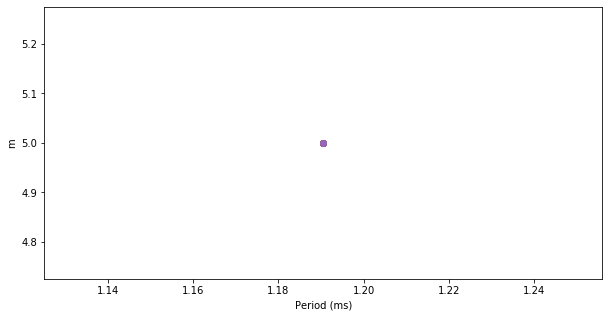

In [24]:
plt.figure(figsize=(10,5))
for i in range(5,100):
    y = self_con_Omega_GRR(m,mass,radius,O=(2*np.pi/i))*1000
    plt.plot(y,m,'o-')
plt.xlabel('Period (ms)')
plt.ylabel('m')
# plt.xlim(1,1.5)
plt.show()

In [14]:
# sv = np.array([200,1,0.1,0.01,0.001])
# sv = np.array([2e3,2e5,2e7,2e9,2e11])
# y = self_con_Omega_GRR(3,1.3,11,0.01,0.01,0)*1000
# print(y)

# mass = 1.5
# radius = 12
# plt.figure(figsize=(10,5))
# for m in range(2,6):
#     y = []
#     for x in sv:
#         y.append(self_con_Omega_GRR(m,mass,radius,x)*1000)
#         plt.annotate(x,(y[-1],m))
#     plt.plot(y,[m,m,m,m,m],'o-')
# plt.xlabel('Period (ms)')
# plt.ylabel('m')
# # plt.xlim(1,1.5)
# plt.show()

# plt.figure(figsize=(10,5))
# for m in range(2,6):
#     y = []
#     for x in sv:
#         y.append(2*np.pi/Omega_GRR(m,mass,radius,x)*1000)
#         plt.annotate(x,(y[-1],m))
#     plt.plot(y,[m,m,m,m,m],'o-')
# plt.xlabel('Period (ms)')
# plt.ylabel('m')
# # plt.xlim(1,1.5)
# plt.show()

In [10]:
basedir = "/Users/laote/sdsu/Research/rotation"
twindir = basedir + "/EOS_twin"

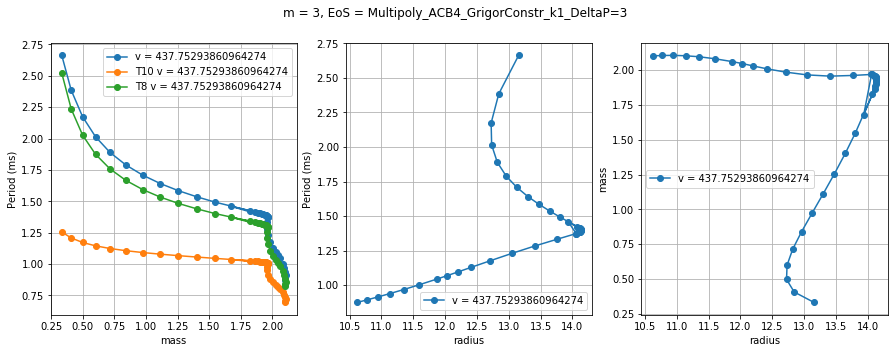

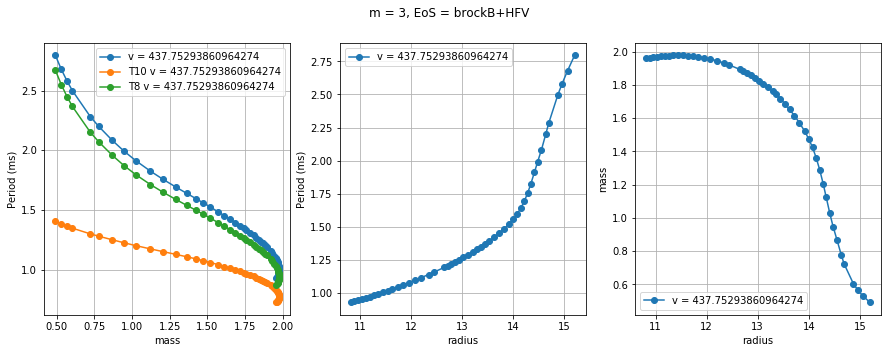

In [25]:
i = 3
datadir = twindir + "/%s.dat" %(i)
dataHT2 = np.genfromtxt(datadir,skip_header=649, skip_footer=1028-710,\
                        names='number,e_c,e_c_e_0,M_gr,M_by,M_pr,R_km,lg_A_rot,lg_I_g_cm2')
NSdir = twindir + "/outputHT.dat__HVfull"
NSHT2 = np.genfromtxt(NSdir,skip_header=753, skip_footer=1196-822,\
                         names='number,e_c,e_c_e_0,M_gr,M_by,M_pr,R_km,lg_A_rot,lg_I_g_cm2')
# NSdir = twindir + "/brockB+HFV.dat"
# NSHT2 = np.genfromtxt(NSdir,skip_header=649, skip_footer=1028-710,\
#                         names='number,e_c,e_c_e_0,M_gr,M_by,M_pr,R_km,lg_A_rot,lg_I_g_cm2')


M_gr = dataHT2['M_gr']
R = dataHT2['R_km']

NSM_gr = NSHT2['M_gr']
NSR = NSHT2['R_km']


T = 1e9 #K
rho = 3*1.4*1.98843e33/(4*np.pi*(13*1e5)**3) # gram cm^-3
bb = 347*rho**(5/4)*T**(-2)


period = []
period_T10 = []
period_T8 = []
for i in range(len(M_gr)):
    period.append(self_con_Omega_GRR(3,M_gr[i],R[i])*1000)
    period_T10.append(self_con_Omega_GRR(3,M_gr[i],R[i],T=1e10)*1000)
    period_T8.append(self_con_Omega_GRR(3,M_gr[i],R[i],T=1e8)*1000)

plt.figure(figsize=(15,5))
plt.suptitle('m = 3, EoS = Multipoly_ACB4_GrigorConstr_k1_DeltaP=3')
plt.subplot(131)
plt.plot(M_gr,period,'o-',label = 'v = %s' %bb)
plt.plot(M_gr,period_T10,'o-',label = 'T10 v = %s' %bb)
plt.plot(M_gr,period_T8,'o-',label = 'T8 v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('mass')
plt.grid()
plt.legend()

plt.subplot(132)
plt.plot(R,period,'o-',label = 'v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.subplot(133)
plt.plot(R,M_gr,'o-',label = 'v = %s' %bb)
plt.ylabel('mass')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.show()



period = []
period_T10 = []
period_T8 = []
for i in range(len(NSM_gr)):
    period.append(self_con_Omega_GRR(3,NSM_gr[i],NSR[i])*1000)
    period_T10.append(self_con_Omega_GRR(3,NSM_gr[i],NSR[i],T=1e10)*1000)
    period_T8.append(self_con_Omega_GRR(3,NSM_gr[i],NSR[i],T=1e8)*1000)
    
plt.figure(figsize=(15,5))
plt.suptitle('m = 3, EoS = brockB+HFV')
plt.subplot(131)
plt.plot(NSM_gr,period,'o-',label = 'v = %s' %bb)
plt.plot(NSM_gr,period_T10,'o-',label = 'T10 v = %s' %bb)
plt.plot(NSM_gr,period_T8,'o-',label = 'T8 v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('mass')
plt.grid()
plt.legend()

plt.subplot(132)
plt.plot(NSR,period,'o-',label = 'v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.subplot(133)
plt.plot(NSR,NSM_gr,'o-',label = 'v = %s' %bb)
plt.ylabel('mass')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.show()

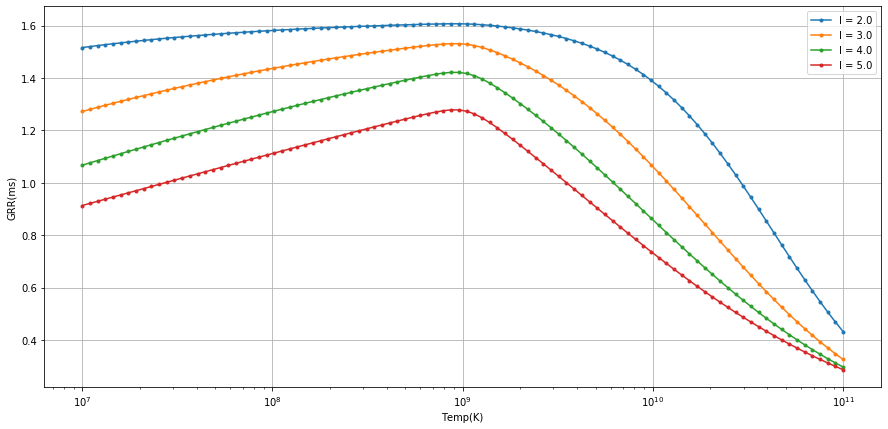

In [45]:
Temp = np.logspace(7,11,100)
 
plt.figure(figsize=(15,7))
for l in range(2,6):
    GRR = []   
    for TE in Temp:
        GRR.append(self_con_Omega_GRR(l,1.5,13.9,T=TE)*1000)
    plt.plot(Temp,GRR,'.-',label='l = %.1f'%l)
plt.xscale('log')
plt.ylabel('GRR(ms)')
plt.xlabel('Temp(K)')
plt.grid()
plt.legend()